In [1]:
from transformers import AutoTokenizer, RobertaModel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import sys
sys.path.append('..')
import utils

In [2]:
data_new = pd.read_json('../data/base/test.json')
data_old = pd.read_json('../data/original/test.json')

tokenizer = AutoTokenizer.from_pretrained("PlanTL-GOB-ES/roberta-base-bne")
def unwrapp(chkpt, size='base'):
    model = RobertaModel.from_pretrained(f"PlanTL-GOB-ES/roberta-{size}-bne")
    model = utils.FakeModel(model, tokenizer=tokenizer)
    model = utils.LightningModel.load_from_checkpoint(chkpt, model=model, tokenizer=tokenizer)
    model = model.model
    return model
model = unwrapp('../models/baseline/lr_1e-6_sch_0.8-step=868.ckpt')

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


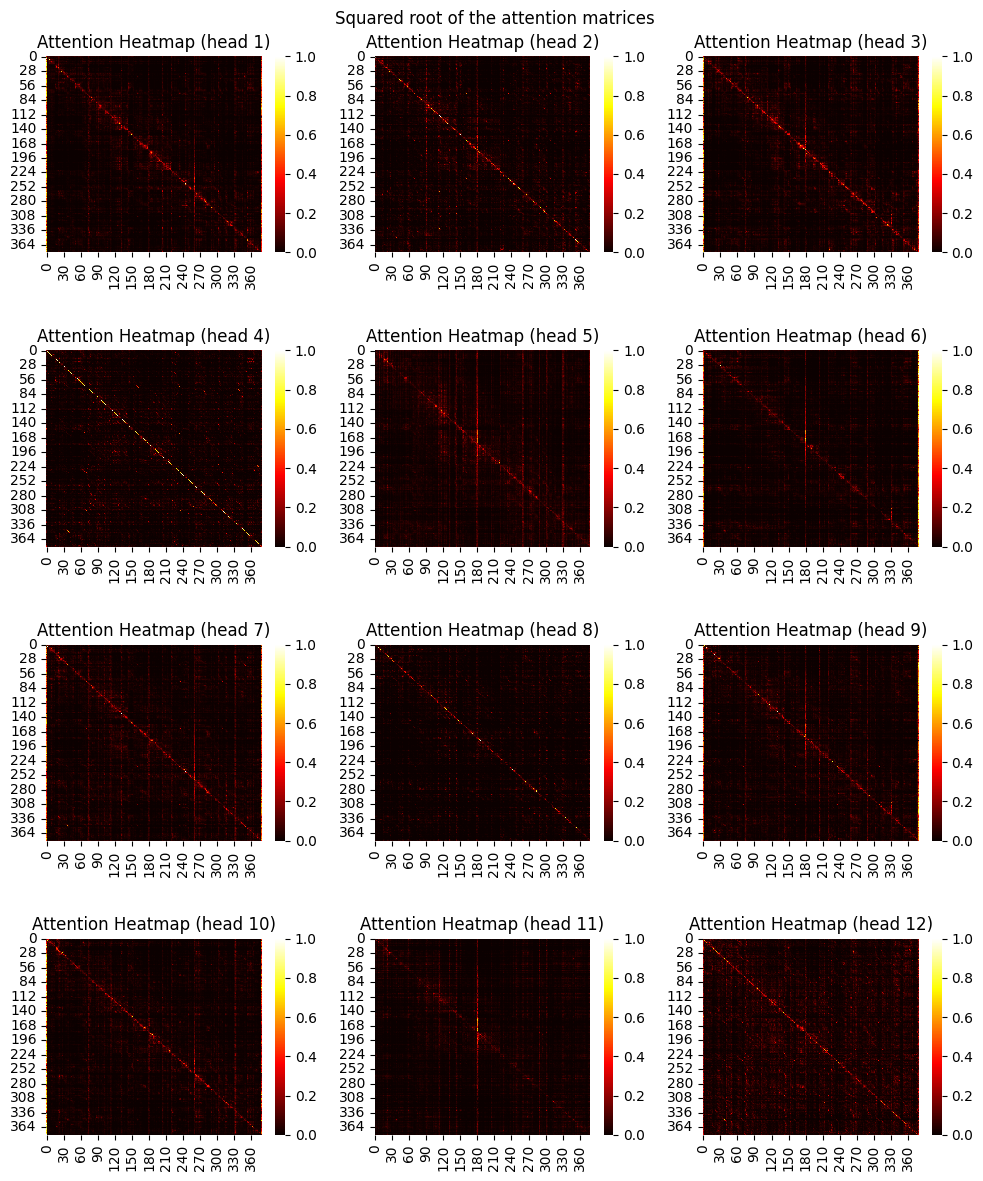

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention(attentions, realzar=True):
    plt.figure(figsize=(10,12))  # Increase the size of the plot
    if realzar:
        plt.suptitle('Squared root of the attention matrices')
    else:
        plt.suptitle('Attention matrices')
    for i in range(len(attentions)):
        # Get the attention values for the first position
        attention_values = attentions[-1][0,i,:,:].detach().cpu().numpy()
        if realzar:
            attention_values = np.sqrt(attention_values)

        plt.subplot(len(attentions) // 3, 3, i + 1,)
        sns.heatmap(attention_values, cmap='hot', cbar=True, vmax=1, vmin=0)
        plt.title(f'Attention Heatmap (head {i+1})')
        #plt.xlabel('Sequence Position')
        #plt.ylabel('Head')
        #plt.ylim(0, attention_values.shape[0])  # Increase the y-axis scale
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

idx = 261
_, attentions = model(data_new['text'][idx], output_attentions=True)
plot_attention(attentions)

# Change of the most attended words with the partitions

In [80]:
import torch
def top_words(attentions, tokenizer, text, n=5):
    # Get the attention values for the first position
    attention_values = attentions.detach().cpu().numpy()
    attention_values = np.sum(attention_values, axis=1)
    tokens = tokenizer.tokenize(text)
    tokens = ['[CLS]'] + tokens + ['[SEP]']
    idxs = np.argsort(attention_values, axis=1)[:,-n:]
    idxs = idxs[:,::-1]
    top = [{}] * len(idxs)
    for i in range(idxs.shape[0]):
        row = idxs[i]
        top[i] = {tokens[t]: attention_values[i,t] / attention_values.shape[0] for t in row}
    return top

def global_top_words(texts, model, tokenizer, batch_size=8, layer=-1):
    top = [{} for _ in range(model.extractor.config.num_attention_heads)]
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            _, attentions = model(texts[i:i+batch_size], output_attentions=True)
            attentions = attentions[layer].cpu()
            for a in range(attentions.shape[0]):
                new_top = top_words(attentions[a], tokenizer, texts[i+a])
                for head in range(len(top)):
                    for word, value in new_top[head].items():
                        if word not in top[head]:
                            top[head][word] = (0,0)
                        top[head][word] = (top[head][word][0] + value, top[head][word][1] + 1)
    return top

def reduce(head, n):
    for word in head:
        head[word] = head[word][0] / head[word][1]
    return dict(sorted(head.items(), key=lambda item: item[1], reverse=True)[:n])

#idx = 261
#_, attentions = model(data_new['text'][idx], output_attentions=True)
#top_words(attentions[0][0], tokenizer, data_new['text'][idx])

In [81]:
top = global_top_words(list(data_new['text']), model, tokenizer, layer=-1)
for i, head in enumerate(top):
    print(f'Head {i+1}')
    print('; '.join([f'{w}:{v:.2f}' for w, v in reduce(head, 5).items()]))
    print()

Token indices sequence length is longer than the specified maximum sequence length for this model (1098 > 512). Running this sequence through the model will result in indexing errors


Head 1
49:15.15; ",:13.61; *:13.48; Ġalude:12.89; Ġmortalidad:11.42

Head 2
*:7.99; [CLS]:7.98; 49:7.93; Ġpara:7.57; !:6.87

Head 3
[CLS]:9.76; *:8.81; Ġequipo:8.18; N:8.17; 49:8.12

Head 4
Ġderiva:4.49; ĠdiscreciÃ³n:4.04; ĠcientÃŃficos:3.76; ĠElla:3.29; Ġbajando:2.80

Head 5
Ġtiempo:18.52; Ġme:17.42; Ġvida:16.56; Ġcandidato:16.36; d:16.03

Head 6
",:26.30; 49:22.98; Ġmuchas:22.81; ĠEl:22.64; ĠJacob:21.87

Head 7
",:14.80; *:13.79; 49:13.63; Ġmortalidad:13.59; Ġpara:12.80

Head 8
[CLS]:19.65; Ġgarganta:6.64; Ġpara:6.15; Ġdos:5.15; Ġmortalidad:4.37

Head 9
",:18.08; 49:16.89; *:16.79; Ġmuchas:16.15; ĠEl:16.01

Head 10
[CLS]:17.33; *:9.30; Ġtiempo:9.01; Ġme:8.85; Ġhacer:8.81

Head 11
",:26.71; Ġmuchas:26.44; ĠEl:25.61; Ġinterna:25.60; ĠJacob:25.15

Head 12
[SEP]:3.52; ':3.51; Ġmortalidad:3.34; 49:3.09; Ġmis:2.74



In [82]:
for topic in data_new['topic'].unique():
    print('############################################')
    print(topic)
    print('############################################')
    top = global_top_words(list(data_new[data_new['topic'] == topic]['text']), model, tokenizer, layer=-1)
    for i, head in enumerate(top):
        print(f'Head {i+1}:' + '; '.join([f'{w}:{v:.2f}' for w, v in reduce(head, 5).items()]))

############################################
Society
############################################
Head 1:",:13.61; Ġalude:12.89; Ġy:11.34; ĠseparaciÃ³n:10.69; Ġmuchas:10.34
Head 2:[CLS]:8.24; ĠSi:6.71; Ġpartidos:6.64; Ġmuchas:6.35; ",:5.88
Head 3:[CLS]:10.04; ĠSi:7.29; Ġalude:7.12; Ġy:6.66; ĠseparaciÃ³n:6.62
Head 4:ĠcientÃŃficos:3.76; ĠElla:3.29; [SEP]:2.92; Ġbajando:2.80; Ġprincipalmente:2.51
Head 5:Ġvida:16.56; ",:15.25; Ġpartidos:14.71; Ġalude:13.87; Ġy:13.87
Head 6:",:26.30; Ġmuchas:22.81; Ġexterno:20.69; ĠSi:18.86; Ġalude:18.85
Head 7:",:14.80; Ġmuchas:12.14; Ġexterno:11.59; ĠseparaciÃ³n:11.50; ĠSi:11.36
Head 8:[CLS]:19.24; Ġy:3.81; [SEP]:3.51; ĠseparaciÃ³n:3.30; Ġequivoca:3.25
Head 9:",:18.08; Ġmuchas:16.15; Ġpartidos:14.55; Ġexterno:14.11; Ġvida:13.76
Head 10:[CLS]:17.46; Ġpartidos:8.72; Ġmuchas:8.44; ",:8.22; Ġy:8.19
Head 11:",:26.71; Ġmuchas:26.44; ĠSi:23.79; Ġexterno:22.12; Ġdel:20.39
Head 12:",:3.67; [SEP]:3.51; Ġmis:2.74; ĠSi:2.74; [CLS]:2.53
###############################

In [83]:
common_data = data_new[data_new['id'].apply(lambda x: 'test' in x)]
common_data['headline'] = common_data['headline'].apply(lambda x: x if x else '')
common_data['input'] = [h + tokenizer.sep_token + t for h, t in zip(common_data['headline'], common_data['text'])]

/tmp/ipykernel_4211/2019829287.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_data['headline'] = common_data['headline'].apply(lambda x: x if x else '')
/tmp/ipykernel_4211/2019829287.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_data['input'] = [h + tokenizer.sep_token + t for h, t in zip(common_data['headline'], common_data['text'])]


### Baseline

In [84]:
base_new = unwrapp('../models/baseline/lr_1e-6_sch_0.8-step=868.ckpt')
#base_old = unwrapp('../models/original/base-step=744.ckpt')
base_large_new = unwrapp('../models/baseline/large-step=372.ckpt',size='large')

attn_new = global_top_words(list(common_data['input']), base_new, tokenizer, layer=-1)
#attn_old = global_top_words(list(common_data['input']), base_old, tokenizer, layer=-1)
attn_large_new = global_top_words(list(common_data['input']), base_large_new, tokenizer, layer=-1)

base_new = None
base_old = None
base_large_new = None

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
for i, head in enumerate(attn_new):
    print(f'')
    print(f'Head {i+1}: ' + '; '.join([f'{w}:{v:.2f}' for w, v in reduce(head, 5).items()]))


Head 1: Ġintervino:13.39; Ġlos:12.63; Ġya:12.41; Ġmovimiento:11.81; Ġmismo:11.40

Head 2: [CLS]:8.07; Ġintervino:7.93; Ġya:6.85; Ġsocial:6.55; Ġviene:5.89

Head 3: [CLS]:9.78; Ġintervino:9.16; Ġlos:8.28; Ġmismo:8.10; Ġya:7.87

Head 4: confidencial:4.39; [SEP]:3.13; ĠisraelÃŃes:2.25; Ġdelicados:2.22; Luego:2.05

Head 5: Ġintervino:18.27; Ġviene:15.46; plas:15.41; Ġya:12.51; Ġmovimiento:12.28

Head 6: Ġintervino:21.10; Ġya:18.82; Ġlos:18.10; ley:17.67; SerÃ¡:17.60

Head 7: Ġintervino:13.68; Ġya:13.57; ĠCDC:12.13; Ġlos:11.83; Ġviene:11.08

Head 8: [CLS]:19.98; Ġya:5.63; Ġsocial:5.27; Ġmismo:5.08; Ġlos:4.76

Head 9: Ġya:15.13; Ġintervino:14.91; Ġviene:13.88; ĠCDC:12.96; ĠaÃ±os:12.35

Head 10: [CLS]:17.40; Ġintervino:10.28; Ġviene:10.18; Ġya:8.94; Ġmismo:8.68

Head 11: Ġintervino:17.85; SerÃ¡:17.71; Ġviene:17.45; ley:16.62; Ġlos:16.25

Head 12: [SEP]:4.43; Ġmismo:2.94; [CLS]:2.91; Ġnuestra:2.72; Ġya:2.63


In [86]:
for i, head in enumerate(attn_large_new):
    print(f'')
    print(f'Head {i+1}: ' + '; '.join([f'{w}:{v:.2f}' for w, v in reduce(head, 5).items()]))


Head 1: AtenciÃ³n:6.38; ON:2.40; #:1.95; /:1.67; [CLS]:1.43

Head 2: [SEP]:1.87; [CLS]:1.78; Se:1.76; Ġun:1.74; plas:1.71

Head 3: AtenciÃ³n:1.98; Ġmachista:1.72; [CLS]:1.45; AG:1.33; Ġviene:1.28

Head 4: [SEP]:1.54; AS:1.49; </s>:1.21; [CLS]:1.11; Ġpersonalidad:1.06

Head 5: ĠgenerÃ³:3.22; ĠPubl:2.87; ĠHabana:2.71; ĠME:2.54; Ġarmadas:2.48

Head 6: MÃģS:2.13; AS:1.97; ĠDEL:1.95; [CLS]:1.28; ENCIAS:1.13

Head 7: [CLS]:4.35; AtenciÃ³n:2.22; Ġcomo:1.91; ley:1.53; Ġtomar:1.52

Head 8: AtenciÃ³n:5.09; Ãį:1.94; Ġmachista:1.82; Ġmandar:1.60; AS:1.38

Head 9: AtenciÃ³n:4.33; AG:3.45; [CLS]:2.54; U:1.20; ĠCÃ³digo:0.96

Head 10: [CLS]:2.51; AtenciÃ³n:1.66; ĠSuc:1.46; Ġvotos:0.94; Ġ:0.91

Head 11: AtenciÃ³n:8.03; Ãį:3.05; Ġempleados:1.94; ĠEST:1.88; Ġrepor:1.73

Head 12: AtenciÃ³n:15.09; [CLS]:2.96; </s>:1.15; [SEP]:0.97; MÃģS:0.93

Head 13: AG:3.02; U:2.19; Ċ:1.49; ĠLaboratorio:1.21; [SEP]:1.07

Head 14: ĠME:2.23; bi:2.14; ĠHabana:1.95; Ġ2008:1.85; Ġfavor:1.83

Head 15: Ċ:2.00; Ġa:1.82; ENCIAS:

### NER mask

In [87]:
from utils import NamedEntityMasker

ner_new = unwrapp('../models/ner_/PER-ORG-conf6-step=310.ckpt')
#ner_old = unwrapp('../models/original/PER-ORG-step=496.ckpt')
ner_large_new = unwrapp('../models/ner_/large-step=620.ckpt',size='large')

masker = NamedEntityMasker(['PER','ORG'])
input_text = [masker(t) for t in common_data['input']]

attn_new = global_top_words(input_text, ner_new, tokenizer, layer=-1)
#attn_old = global_top_words(input_text, ner_old, tokenizer, layer=-1)
attn_large_new = global_top_words(input_text, ner_large_new, tokenizer, layer=-1)

ner_new = None
ner_old = None
ner_large_new = None

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
for i, head in enumerate(attn_new):
    print(f'')
    print(f'Head {i+1}: ' + '; '.join([f'{w}:{v:.2f}' for w, v in reduce(head, 5).items()]))


Head 1: bajo:19.18; cioso:16.04; Ġparticular:14.97; Ġdos:14.59; Ġprimer:14.05

Head 2: ĠCo:14.30; MS:13.55; bajo:12.24; ĠmÃ¡s:12.01; cioso:11.74

Head 3: bajo:14.08; cioso:12.15; ĠEn:10.48; ulta:10.18; Ġlav:9.94

Head 4: Ġsirven:6.80; confidencial:6.56; Ġdelicados:5.91; ĠCuba:5.17; [SEP]:4.70

Head 5: MS:25.56; bajo:23.72; Ġrecordando:20.86; cioso:20.49; Ġdos:18.76

Head 6: bajo:27.11; cioso:26.87; Ġparticular:25.67; ĠEn:24.99; Ġse:24.14

Head 7: bajo:19.07; cioso:17.20; Ġdos:16.09; MS:15.35; Ġparticular:15.19

Head 8: [CLS]:14.57; Ġsiempre:8.77; Ġedificio:8.60; bajo:8.35; Ġprueba:8.34

Head 9: MS:21.65; bajo:21.20; cioso:20.48; Ġrecordando:18.93; ĠEn:18.35

Head 10: bajo:16.50; MS:13.49; cioso:12.80; [CLS]:12.61; Ġrecordando:12.46

Head 11: Ġparticular:26.04; ĠEn:22.40; cioso:21.43; Ġprimer:20.69; bajo:20.16

Head 12: [SEP]:4.27; Ġestudios:3.24; ulta:3.17; Ġpor:3.08; Ġprueba:2.87


In [89]:
for i, head in enumerate(attn_large_new):
    print(f'')
    print(f'Head {i+1}: ' + '; '.join([f'{w}:{v:.2f}' for w, v in reduce(head, 5).items()]))


Head 1: ON:2.00; /:1.45; [CLS]:1.20; _:1.16; #:1.10

Head 2: Ġtercera:1.52; [CLS]:1.41; Ġcreado:1.31; Ġrecordando:1.30; mente:1.28

Head 3: [CLS]:1.67; Ġtercera:1.32; Ġmachista:1.15; Ġcreado:1.11; Ġcomo:1.09

Head 4: ĠMA:1.42; [SEP]:1.20; Ġbasura:1.17; [CLS]:0.97; </s>:0.96

Head 5: Ġquincena:4.09; ĠPubl:3.39; Quienes:3.13; ĠHabana:2.36; Ġarmadas:2.24

Head 6: ĠPOR:1.41; </s>:0.82; AS:0.78; Ġdescuento:0.74; ĠRock:0.72

Head 7: [CLS]:2.48; Ġtercera:1.48; cioso:1.04; ":1.04; Ġcreado:1.00

Head 8: Ġmachista:1.96; Ãį:1.79; Ġquincena:1.49; izados:1.21; Como:1.00

Head 9: [CLS]:1.72; ON:1.15; UN:1.05; ĠCÃ³digo:0.84; AG:0.81

Head 10: Ġdescuento:1.27; </s>:1.19; Ġ:1.17; ĠSuc:1.14; [CLS]:1.07

Head 11: Ġrepor:2.04; Ãį:1.62; ON:1.48; #:1.47; Ġempleados:1.41

Head 12: [CLS]:2.08; _:0.99; impor:0.79; Ġbomba:0.73; Ġviral:0.72

Head 13: Ċ:1.34; VA:1.31; ĠinformÃ³:1.16; *,:0.88; U:0.84

Head 14: ĠHabana:2.14; bi:1.80; ĠME:1.77; Ġ2008:1.65; ĠpolÃ©mica:1.53

Head 15: Ċ:1.98; ":1.14; ĠInglaterra:1.04;

### Backtranslation

In [90]:
new_back = unwrapp('../models/backtranslation/pipe5-step=744-v1.ckpt')
#old_back = unwrapp('../models/original/pipe5-step=680.ckpt')
new_large_back = unwrapp('../models/backtranslation/large-step=494.ckpt',size='large')


attn_new = global_top_words(list(common_data['input']), new_back, tokenizer, layer=-1)
#attn_old = global_top_words(list(common_data['input']), old_back, tokenizer, layer=-1)
attn_large_new = global_top_words(list(common_data['input']), new_large_back, tokenizer, layer=-1)

new_back = None
old_back = None
new_large_back = None

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [91]:
for i, head in enumerate(attn_new):
    print(f'')
    print(f'Head {i+1}: ' + '; '.join([f'{w}:{v:.2f}' for w, v in reduce(head, 5).items()]))


Head 1: ĠaÃ±os:14.20; ĠaprobaciÃ³n:14.02; non:12.97; Ġlugar:11.92; Ġya:11.40

Head 2: ĠcompaÃ±ÃŃa:6.02; Ġcadena:5.12; Ġhallazgos:5.09; Ġvac:4.95; ĠaprobaciÃ³n:4.54

Head 3: ĠaÃ±os:9.98; non:9.12; ĠevalÃºa:9.03; ĠradiaciÃ³n:8.75; ĠaprobaciÃ³n:8.59

Head 4: ĠChile:6.12; SU:3.32; Ġpand:3.25; ĠAle:3.09; ĠaÃ±adiÃ³:2.93

Head 5: ĠCul:10.49; Ġdeben:10.17; non:9.82; ĠaprobaciÃ³n:9.55; ĠevalÃºa:8.01

Head 6: ĠaprobaciÃ³n:18.93; non:18.82; ĠradiaciÃ³n:17.44; ĠaÃ±os:17.43; Ġdecir:17.29

Head 7: ĠradiaciÃ³n:8.86; ĠaprobaciÃ³n:8.82; non:8.74; ĠaÃ±os:8.69; Ġya:8.49

Head 8: Ġvac:6.75; Ġdicha:6.25; non:5.62; [CLS]:5.60; Ġdistancia:5.40

Head 9: ĠaprobaciÃ³n:12.70; ĠradiaciÃ³n:12.31; Ġya:12.28; non:12.03; ĠaÃ±os:11.72

Head 10: [CLS]:10.07; Ġhallazgos:9.74; non:9.60; Ġdeben:9.21; ĠaÃ±os:9.18

Head 11: ĠaprobaciÃ³n:15.12; non:14.92; ĠCul:14.47; ĠDelegaciÃ³n:13.72; Ġya:13.71

Head 12: Ġlos:7.24; Ġya:6.96; Ġcuando:6.30; Ġlas:6.15; Ġvac:6.03


In [92]:
for i, head in enumerate(attn_large_new):
    print(f'')
    print(f'Head {i+1}: ' + '; '.join([f'{w}:{v:.2f}' for w, v in reduce(head, 5).items()]))


Head 1: ON:5.54; /:2.21; Ġinicio:2.09; AtenciÃ³n:1.90; @:1.48

Head 2: Ġviene:1.67; ĠinformÃ³:1.65; Ċ:1.62; plas:1.56; Se:1.55

Head 3: Ġnuestra:1.87; Ġviene:1.80; Ċ:1.57; Ġemisiones:1.49; Ġsu:1.42

Head 4: Ċ:1.99; [SEP]:1.99; [CLS]:1.34; </s>:1.12; Ġhospital:0.95

Head 5: ĠHabana:4.88; ĠPubl:4.08; Ġcentra:3.09; ĠgenerÃ³:3.08; Ġbasura:3.04

Head 6: MÃģS:2.20; [CLS]:1.82; ĠAnton:1.45; ::1.25; gue:1.24

Head 7: [CLS]:3.61; Ġcomo:1.85; ley:1.76; Ġtomar:1.54; lum:1.39

Head 8: Ġmachista:2.17; Ġequipo:2.14; ceo:2.14; Ġestudiante:2.08; izados:1.81

Head 9: AtenciÃ³n:6.21; AG:2.46; [CLS]:1.63; Ċ:1.11; ĠinformÃ³:1.09

Head 10: [CLS]:2.94; ĠSuc:2.45; Ċ:1.77; AtenciÃ³n:1.64; Y:1.34

Head 11: AtenciÃ³n:4.11; Ġempleados:3.34; osas:2.97; ĠEST:2.54; Ġrepor:2.19

Head 12: AtenciÃ³n:8.90; [CLS]:2.49; Ċ:1.46; AG:0.95; ?:0.91

Head 13: AG:2.81; Ċ:2.61; ĠFranklin:1.78; U:1.52; ĠinformÃ³:1.45

Head 14: ĠHabana:4.49; ON:4.35; bi:3.59; ĠinformÃ³:2.98; ĠpolÃ©mica:2.57

Head 15: Ċ:2.94; ĠsÃ¡bado:2.13; MÃģS:1

### Noisy embeddings

In [93]:
noisy_new = unwrapp('../models/noisy_emb/uniform_10-step=992.ckpt')
#noisy_old = unwrapp('../models/original/noisy_emb-step=595.ckpt')
noisy_large_new = unwrapp('../models/noisy_emb/large-step=744.ckpt',size='large')

attn_new = global_top_words(list(common_data['input']), noisy_new, tokenizer, layer=-1)
#attn_old = global_top_words(list(common_data['input']), noisy_old, tokenizer, layer=-1)
attn_large_new = global_top_words(list(common_data['input']), noisy_large_new, tokenizer, layer=-1)

noisy_new = None
noisy_old = None
noisy_large_new = None

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [94]:
for i, head in enumerate(attn_new):
    print('')
    print(f'Head {i+1}: ' + '; '.join([f'{w}:{v:.2f}' for w, v in reduce(head, 5).items()]))


Head 1: Ġemisiones:18.96; ley:15.16; Ġintervino:14.62; Ġculmin:13.11; ĠComisiÃ³n:12.93

Head 2: Ġcolonia:9.15; Ġemisiones:7.38; Ġsocial:7.23; Ġintervino:6.64; ley:6.59

Head 3: Ġemisiones:11.62; Ġintervino:10.45; [CLS]:9.84; ley:8.30; Ġculmin:8.00

Head 4: ĠLGTB:5.86; ĠisraelÃŃes:5.36; Ġchiringuitos:4.21; Ġmodificado:4.00; ĠWhatsApp:3.62

Head 5: Ġviene:16.04; plas:16.00; Ġintervino:15.58; Ġemisiones:15.31; SerÃ¡:15.08

Head 6: Ġemisiones:27.09; ley:25.52; SerÃ¡:24.48; Ġa:22.05; Ġregula:21.63

Head 7: Ġemisiones:13.99; ley:12.80; Ġsocial:12.34; Ġintervino:12.01; Ġculmin:10.90

Head 8: [CLS]:15.06; Ġsocial:7.85; Ġintervino:6.01; Ġemisiones:5.38; [SEP]:5.05

Head 9: Ġemisiones:16.91; ley:15.85; SerÃ¡:15.70; ::15.05; Ġculmin:13.21

Head 10: [CLS]:13.36; Ġemisiones:12.02; Ġintervino:11.08; Ġviene:10.08; Ġsocial:9.22

Head 11: Ġemisiones:22.83; ley:22.57; SerÃ¡:22.46; Ġsu:20.57; Ġculmin:19.42

Head 12: Ġemisiones:6.65; Ġculmin:5.39; SerÃ¡:5.38; Ġmen:5.15; [SEP]:4.71


In [95]:
for i, head in enumerate(attn_large_new):
    print('')
    print(f'Head {i+1}: ' + '; '.join([f'{w}:{v:.2f}' for w, v in reduce(head, 5).items()]))


Head 1: AtenciÃ³n:5.85; ON:1.99; #:1.29; /:1.26; [CLS]:1.12

Head 2: [SEP]:1.63; [CLS]:1.37; Ġ2:1.29; unar:1.28; Ġel:1.28

Head 3: AtenciÃ³n:1.57; [CLS]:1.42; Ġviene:1.12; Ġemisiones:1.07; [SEP]:1.06

Head 4: [SEP]:1.37; </s>:1.14; [CLS]:1.02; Ċ:0.89; Ġla:0.83

Head 5: ĠPubl:2.08; ĠHabana:1.78; ENCIAS:1.72; izados:1.70; ĠgenerÃ³:1.59

Head 6: </s>:0.94; [CLS]:0.84; ĠDEL:0.84; ::0.83; ĠEcuador:0.78

Head 7: [CLS]:2.03; Ġcomo:1.48; AtenciÃ³n:1.41; Ġtomar:1.33; ley:1.22

Head 8: AtenciÃ³n:2.43; Ġmachista:1.74; ENCIAS:1.22; Como:1.15; Ġmandar:1.14

Head 9: AtenciÃ³n:3.00; AG:2.93; [CLS]:1.84; Ġde:0.95; U:0.88

Head 10: ĠSuc:1.54; AtenciÃ³n:1.53; car:1.13; Ã©:1.11; Ġ:1.00

Head 11: AtenciÃ³n:4.51; Ġrepor:2.58; Ġcifra:1.18; U:1.15; ĠEST:1.03

Head 12: AtenciÃ³n:7.91; [CLS]:2.09; Ġregula:1.09; [SEP]:1.03; tin:1.03

Head 13: AG:3.02; U:1.62; Ċ:1.44; [SEP]:1.02; Ġviene:1.01

Head 14: ON:1.67; Ġlas:1.50; bi:1.45; Ġfavor:1.34; ĠHabana:1.33

Head 15: Ċ:1.85; Ġa:1.61; </s>:1.30; [SEP]:1.18; Atenci

# Long context: attention over the regions

In [4]:
common_data = data_new[data_new['id'].apply(lambda x: 'test' in x)]
common_data['headline'] = common_data['headline'].apply(lambda x: x if x else '')
common_data['input'] = [h + tokenizer.sep_token + t for h, t in zip(common_data['headline'], common_data['text'])]

/tmp/ipykernel_16700/2019829287.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_data['headline'] = common_data['headline'].apply(lambda x: x if x else '')
/tmp/ipykernel_16700/2019829287.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_data['input'] = [h + tokenizer.sep_token + t for h, t in zip(common_data['headline'], common_data['text'])]


In [6]:
import torch

def unwrapp_belt(chkpt, tokenizer, size='base'):
    model = RobertaModel.from_pretrained(f"PlanTL-GOB-ES/roberta-{size}-bne")
    model = utils.FakeBELT(model, tokenizer=tokenizer, pool='transf',max_length=2500)
    model = utils.LightningModel.load_from_checkpoint(chkpt, model=model, tokenizer=tokenizer)
    return model.model

def get_global_attn(texts, model):
    '''
    Get the attention of the model for all the given texts

    Parameters:
        texts (list): A list of texts to get the attention from
        model (FakeModel): The model to get the attention from
    
    Returns:
        torch.Tensor: The attention of the model for all the texts in a single tensor
        torch.Tensor: The mask of the attention tensor
    '''
    MAX = max(int((2500 - 510) / (model.step * 510))+2,0)
    global_attn = []
    mask = []
    with torch.no_grad():
        for i in range(0, len(texts)):
            _, attentions = model(texts[i], output_attentions=True)
            framed = torch.zeros(8,MAX,MAX)
            framed[:,:attentions.shape[2],:attentions.shape[3]] = attentions.cpu()[0]
            global_attn.append(framed)
            framed_mask = torch.zeros(8,MAX,MAX)
            framed_mask[:,:attentions.shape[2],:attentions.shape[3]] = 1
            mask.append(framed_mask)
    return torch.stack(global_attn), torch.stack(mask)

def plot_attention(attentions, title=''):
    plt.figure(figsize=(12,6))
    if title:
        plt.suptitle(title)
    for i in range(attentions.shape[0]):
        plt.subplot(2, 4, i + 1)
        sns.heatmap(attentions[i], cmap='hot', cbar=True, vmax=1, vmin=0)#, annot=dev[i], fmt='.1f')
        plt.title(f'Head {i+1}')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

#attentions, mask = get_global_attn(list(data_new['text']), model)
#mean_attn = attentions.sum(dim=0) / torch.count_nonzero(mask, dim=0)
#dev = torch.where(mask != 0, torch.unsqueeze(mean_attn, 0).expand(attentions.shape[0],-1,-1,-1) - attentions, torch.zeros_like(attentions))
#dev = (dev.square().sum(dim=0) / torch.count_nonzero(mask, dim=0)).sqrt()

## New Partitions

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


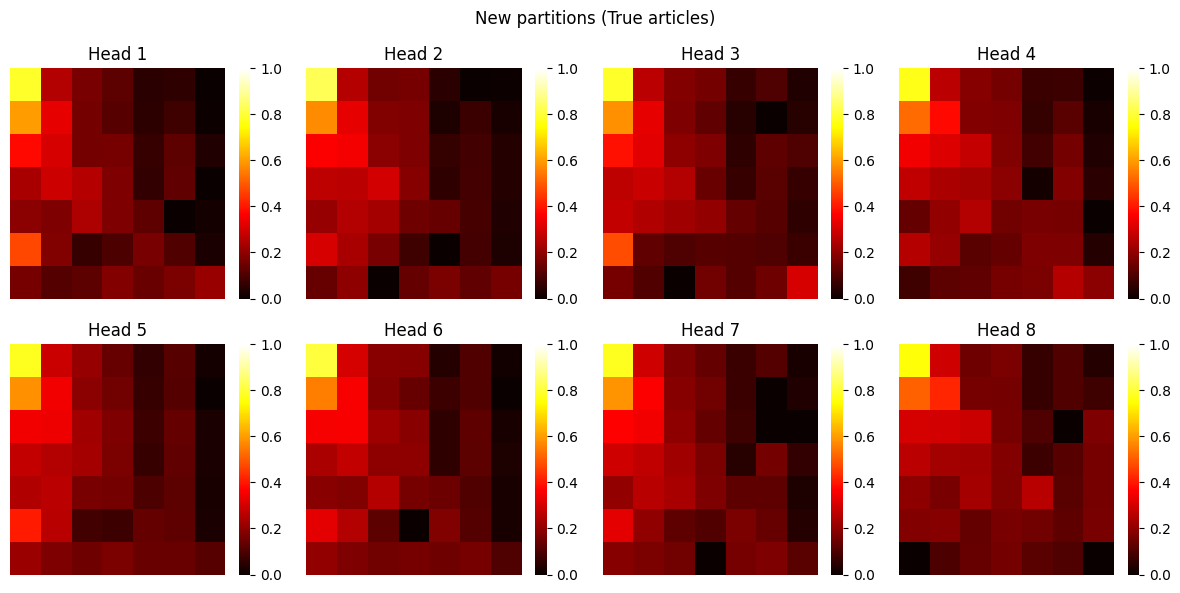

In [7]:
full_new = unwrapp_belt('../models/full_length/full_length-step=992.ckpt', tokenizer)
data_full = pd.read_json('../data/predictions/full_length.json')
true_data = data_full[(data_full['predictions'] == 'True') & (data_full['category'] == 'True')]
attentions, mask = get_global_attn(list(true_data['text']), full_new)
mean_attn_new_true = attentions.sum(dim=0) / torch.count_nonzero(mask, dim=0)
plot_attention(mean_attn_new_true,title='New partitions (True articles)')
full_new = None

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


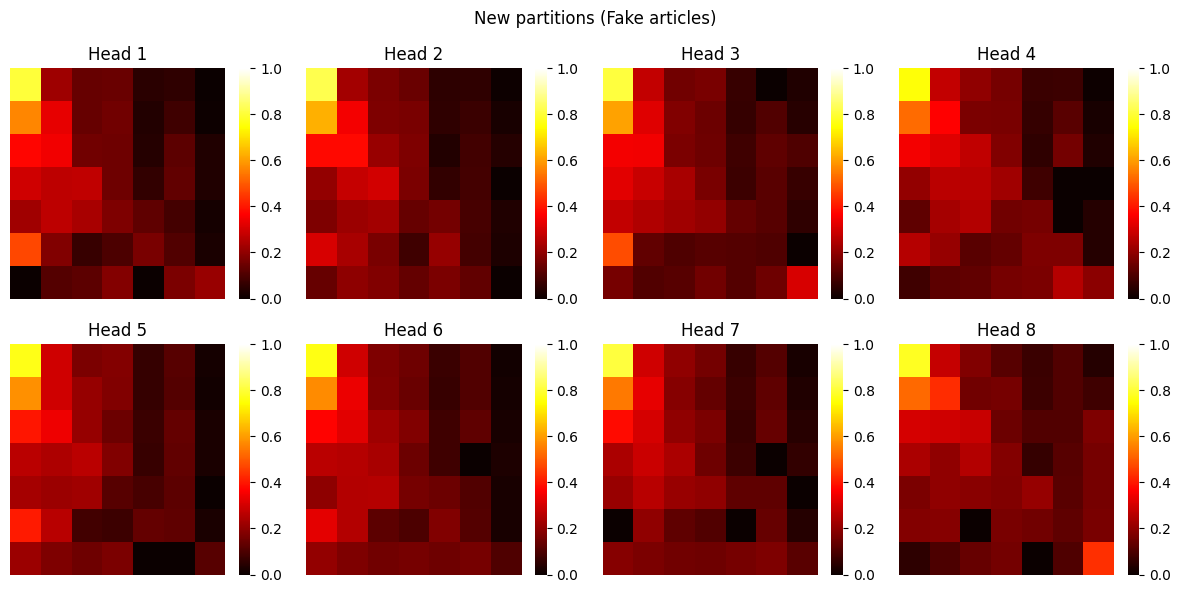

In [8]:
full_new = unwrapp_belt('../models/full_length/full_length-step=992.ckpt', tokenizer)
fake_data = data_full[(data_full['predictions'] == 'Fake') & (data_full['category'] == 'Fake')]
attentions, mask = get_global_attn(list(true_data['text']), full_new)
mean_attn_new_fake = attentions.sum(dim=0) / torch.count_nonzero(mask, dim=0)
plot_attention(mean_attn_new_fake,title='New partitions (Fake articles)')
full_new = None

## Original partitions

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


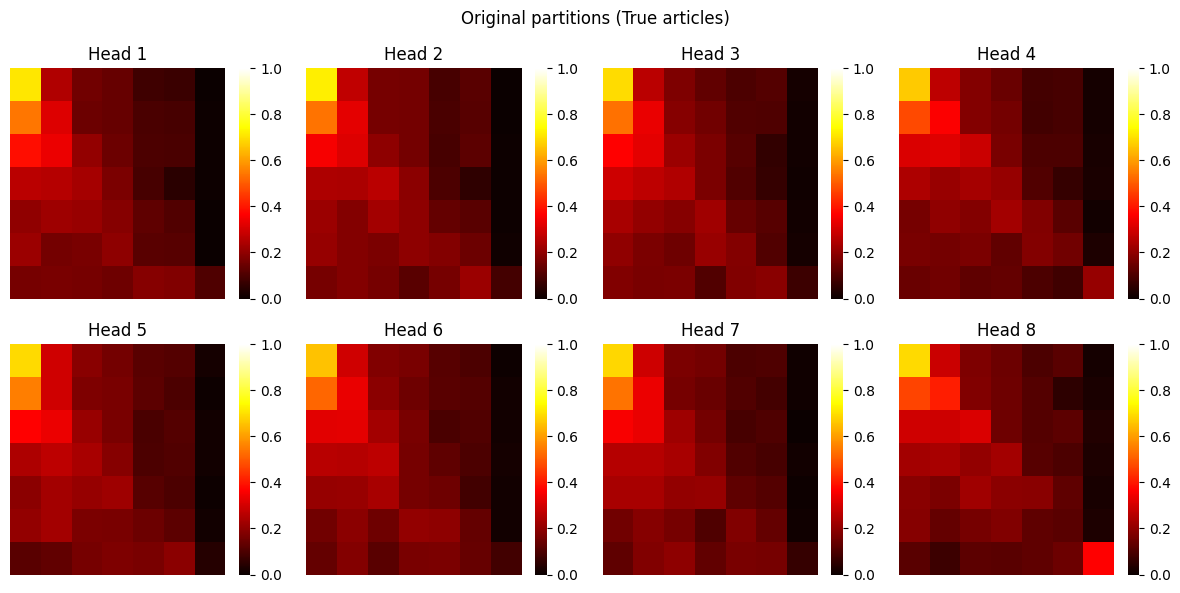

In [9]:
full_old = unwrapp_belt('../models/full_length/full_length-step=992.ckpt', tokenizer)
data_full = pd.read_json('../data/orig_preds/full_length.json')
true_data = data_full[(data_full['predictions'] == 'True') & (data_full['category'] == 'True')]
attentions, mask = get_global_attn(list(true_data['text']), full_old)
mean_attn_old_true = attentions.sum(dim=0) / torch.count_nonzero(mask, dim=0)
plot_attention(mean_attn_old_true,title='Original partitions (True articles)')
full_old = None

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


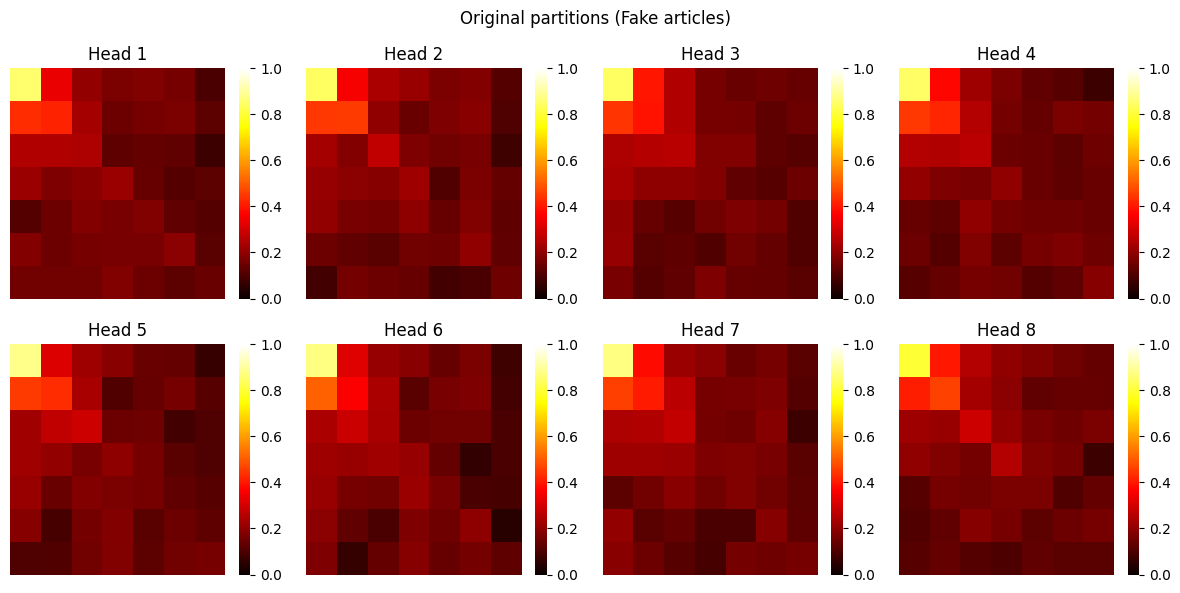

In [10]:
full_old = unwrapp_belt('../models/full_length/full_length-step=992.ckpt', tokenizer)
data_full = pd.read_json('../data/orig_preds/full_length.json')
fake_data = data_full[(data_full['predictions'] == 'Fake') & (data_full['category'] == 'Fake')]
attentions, mask = get_global_attn(list(fake_data['text']), full_old)
mean_attn_old_fake = attentions.sum(dim=0) / torch.count_nonzero(mask, dim=0)
plot_attention(mean_attn_old_fake,title='Original partitions (Fake articles)')
full_old = None

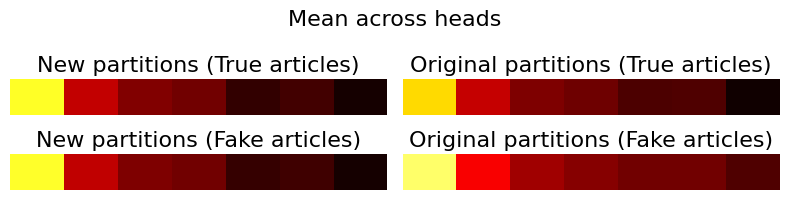

In [14]:
plt.figure(figsize=(8,2))
plt.suptitle('Mean across heads', fontsize=16)
plt.subplot(2,2,1)
sns.heatmap(torch.unsqueeze(mean_attn_new_true.mean(dim=0)[0],0), cmap='hot', cbar=False, vmax=1, vmin=0)#, annot=True)
plt.xticks([])
plt.yticks([])
plt.title('New partitions (True articles)', fontsize=16)

plt.subplot(2,2,2)
sns.heatmap(torch.unsqueeze(mean_attn_old_true.mean(dim=0)[0],0), cmap='hot', cbar=False, vmax=1, vmin=0)#, annot=True)
plt.xticks([])
plt.yticks([])
plt.title('Original partitions (True articles)', fontsize=16)

plt.subplot(2,2,3)
sns.heatmap(torch.unsqueeze(mean_attn_new_fake.mean(dim=0)[0],0), cmap='hot', cbar=False, vmax=1, vmin=0)#, annot=True)
plt.xticks([])
plt.yticks([])
plt.title('New partitions (Fake articles)', fontsize=16)

plt.subplot(2,2,4)
sns.heatmap(torch.unsqueeze(mean_attn_old_fake.mean(dim=0)[0],0), cmap='hot', cbar=False, vmax=1, vmin=0)#, annot=True)
plt.xticks([])
plt.yticks([])
plt.title('Original partitions (Fake articles)', fontsize=16)

plt.tight_layout()
plt.show()

# Named Entities

In [4]:
import re
import spacy
from utils import NamedEntityMasker

recognizer = spacy.load('es_core_news_sm')
masker = NamedEntityMasker(['PER','ORG'])

def find(offsets, start, end):
    '''
    Find the offsets that contain the given start and end positions
    '''
    ini = -1
    fin = -1
    for i in range(len(offsets)):
        if offsets[i][0] <= start:
            ini = i
        if offsets[i][1] >= end:
            fin = i
            break
    if fin < ini:
        return ini, offsets[-2][1]
    return ini, fin

def attn_re(pattern, text, offset, attn):
    '''
    Get the attention that the model pays to the given regex pattern over the text
    '''
    attention = 0
    count = 0
    for match in re.finditer(pattern,text):
        i,j = find(offset, match.start(), match.end())
        attention += attn[:,0,i:j+1].sum(axis=0).mean()
        count += 1
    return attention, count

def ents_attn(text, model, tokenizer, masks=[]):
    '''
    Get the attention that the model pays to each of the entities in the text
    '''
    attentions = {}
    counts = {}
    with torch.no_grad():
        _, attn = model(text, output_attentions=True)
        attn = attn[-1][0].cpu().detach().numpy()
    doc = recognizer(text)
    offsets = tokenizer(text,return_offsets_mapping=True, max_length=tokenizer.model_max_length)['offset_mapping']
    for ent in doc.ents:
        i, j = find(offsets, ent.start_char, ent.end_char)
        attentions[ent.label_] = attentions.get(ent.label_,0) + attn[:,0,i:j+1].sum(axis=0).mean()
        counts[ent.label_] = counts.get(ent.label_,0) + 1
    attentions['phones'], counts['phones'] = attn_re(r'\b(?:\+?1[-.\s]?)?(?:\(?[2-9]\d{2}\)?[-.\s]?){1,2}\d{4}\b',text,offsets,attn)
    attentions['urls'], counts['urls'] = attn_re(r'\b(?:https?://)?(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b',text,offsets,attn)
    attentions['numbers'], counts['numbers'] = attn_re(r'\d+',text,offsets,attn)
    for mask in masks:
        attentions[mask], counts[mask] = attn_re(mask,text,offsets,attn)
    for m in counts:
        attentions[m] /= counts[m] if counts[m] else 1
    return attentions

def global_ents_attn(texts, model, tokenizer, masks=[]):
    attentions = {}
    counts = {}
    for text in texts:
        att = ents_attn(text, model, tokenizer, masks=masks)
        for id in att:
            attentions[id] = attentions.get(id,0) + att[id]
            counts[id] = counts.get(id,0) + 1
    for id in attentions:
        attentions[id] /= counts[id]
    return attentions

def mask_entities(df):
    df['text'] = df['text'].apply(lambda x: re.sub(r'\b(?:\+?1[-.\s]?)?(?:\(?[2-9]\d{2}\)?[-.\s]?){1,2}\d{4}\b','*PHONE*',x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'\b(?:https?://)?(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b','*URL*',x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'\d+','*NUMBER*',x))
    df['text'] = df['text'].apply(lambda x: masker(x))
    return df

def get_mean(report):
    attn = 0
    for k in report:
        attn += report[k]
    return attn / len(report)

## New partitions

### code

Base size models

In [5]:
base = unwrapp('../models/baseline/lr_1e-6_sch_0.8-step=868.ckpt')
base_ent_attn_new = global_ents_attn(list(data_new['text']), base, tokenizer)
base = None
print(base_ent_attn_new)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'LOC': 0.14956989056224612, 'MISC': 0.14680047213879935, 'ORG': 0.14963589864897017, 'PER': 0.1503402102963163, 'phones': 4.317995739503971e-05, 'urls': 0.05504401890866465, 'numbers': 0.06258473496238513}


In [6]:
ner = unwrapp('../models/ner_/PER-ORG-conf6-step=310.ckpt')
masker = utils.NamedEntityMasker(['PER','ORG'])
masked_data = mask_entities(data_new.copy())
masked_data = [masker(t) for t in masked_data['text']]
ner_ent_attn_new = global_ents_attn(masked_data, ner, tokenizer, ['PER','ORG'])
ner = None
print(ner_ent_attn_new)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'LOC': 0.14630321946432812, 'MISC': 0.14165556280690497, 'phones': 0.0, 'urls': 0.0, 'numbers': 0.0, 'PER': 0.14748875444711537, 'ORG': 0.12857341185605964}


In [7]:
external = unwrapp('../models/ext_diverse/diverse_1500-step=992.ckpt')
ext_attn_new = global_ents_attn(list(data_new['text']), external, tokenizer)
external = None
print(ext_attn_new)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'LOC': 0.11841351220520574, 'MISC': 0.11430626382834523, 'ORG': 0.11690100845495406, 'PER': 0.11455417919792424, 'phones': 2.0573045274779247e-05, 'urls': 0.041782653854429246, 'numbers': 0.047014524525715674}


In [8]:
back = unwrapp('../models/backtranslation/pipe5-step=744-v1.ckpt')
back_ent_attn_new = global_ents_attn(list(data_new['text']), back, tokenizer)
back = None
print(back_ent_attn_new)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'LOC': 0.07777560616846108, 'MISC': 0.0563847889945722, 'ORG': 0.05911784420056087, 'PER': 0.05018452576572973, 'phones': 1.458848094187894e-05, 'urls': 0.011639084517727279, 'numbers': 0.01741846678230776}


In [9]:
noisy_emb = unwrapp('../models/noisy_emb/uniform_10-step=992.ckpt')
noisy_ent_attn_new = global_ents_attn(list(data_new['text']), noisy_emb, tokenizer)
noisy_emb = None
print(noisy_ent_attn_new)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'LOC': 0.1649653953907996, 'MISC': 0.16425477365840252, 'ORG': 0.1676010073237623, 'PER': 0.16698165097791182, 'phones': 3.2932274525798255e-05, 'urls': 0.058024450115822204, 'numbers': 0.07134289652567388}


Large models

In [10]:
large_base = unwrapp('../models/baseline/large-step=372.ckpt',size='large')
large_base_ent_attn_new = global_ents_attn(list(data_new['text']), large_base, tokenizer)
large_base = None
print(large_base_ent_attn_new)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'LOC': 0.07872281309490274, 'MISC': 0.0756383097167172, 'ORG': 0.07831971800407139, 'PER': 0.0745603574676389, 'phones': 0.00016769774041129547, 'urls': 0.021122297400798195, 'numbers': 0.02854514734802765}


In [11]:
large_ner = unwrapp('../models/ner_/large-step=620.ckpt',size='large')
masker = utils.NamedEntityMasker(['PER','ORG'])
masked_data = mask_entities(data_new.copy())
masked_data = [masker(t) for t in masked_data['text']]
large_ner_ent_attn_new = global_ents_attn(masked_data, large_ner, tokenizer, ['PER','ORG'])
large_ner = None
print(large_ner_ent_attn_new)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'LOC': 0.07910759484916632, 'MISC': 0.06750607791330117, 'phones': 0.0, 'urls': 0.0, 'numbers': 0.0, 'PER': 0.06008258591540113, 'ORG': 0.043678942624326624}


In [12]:
large_external = unwrapp('../models/ext_diverse/large_1500-step=865.ckpt', size='large')
large_ext_ent_attn_new = global_ents_attn(list(data_new['text']), large_external, tokenizer)
large_external = None
print(large_ext_ent_attn_new)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'LOC': 0.07181929738868632, 'MISC': 0.06639268356787334, 'ORG': 0.07064082919196728, 'PER': 0.06595916076786225, 'phones': 0.00014806250682926486, 'urls': 0.016573045920028697, 'numbers': 0.023142552422998786}


In [13]:
large_back = unwrapp('../models/backtranslation/large-step=494.ckpt',size='large')
large_back_ent_attn_new = global_ents_attn(list(data_new['text']), large_back, tokenizer)
large_back = None
print(large_back_ent_attn_new)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'LOC': 0.07209241623772522, 'MISC': 0.06782314422984254, 'ORG': 0.06984859027981416, 'PER': 0.06580539739127059, 'phones': 0.0001898363931858038, 'urls': 0.01677440160769722, 'numbers': 0.023274239517738698}


In [14]:
large_noisy_emb = unwrapp('../models/noisy_emb/large-step=744.ckpt',size='large')
large_noisy_ent_attn_new = global_ents_attn(list(data_new['text']), large_noisy_emb, tokenizer)
large_noisy_emb = None
print(large_noisy_ent_attn_new)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'LOC': 0.07105735167285213, 'MISC': 0.06934251352825042, 'ORG': 0.07095642041525511, 'PER': 0.06812708316902379, 'phones': 0.00016109476583289482, 'urls': 0.01893410671742153, 'numbers': 0.025598526960110692}


### results

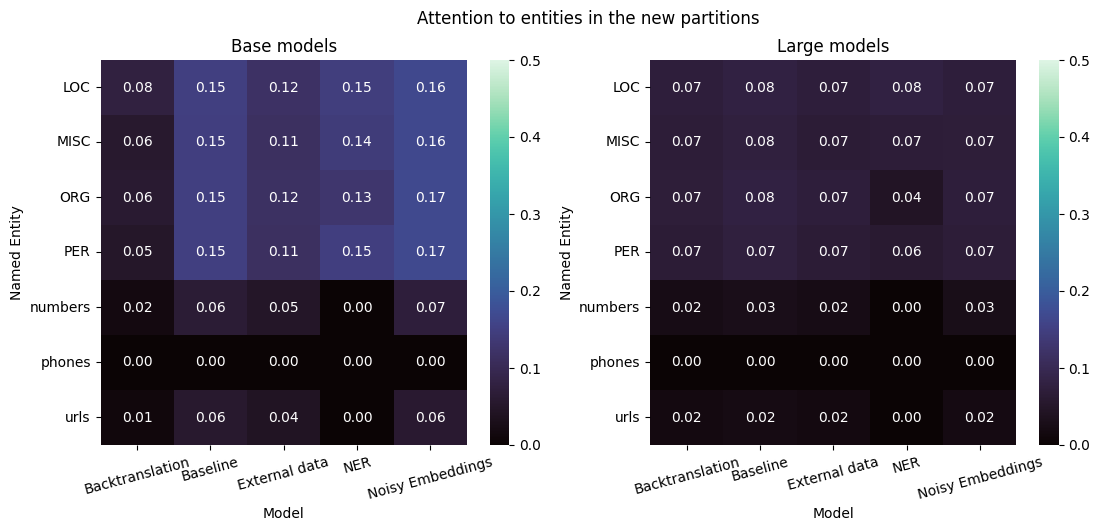

In [15]:
reports_new = [base_ent_attn_new,ner_ent_attn_new,ext_attn_new,back_ent_attn_new,noisy_ent_attn_new]
large_reports_new = [large_base_ent_attn_new,large_ner_ent_attn_new,large_ext_ent_attn_new,large_back_ent_attn_new,large_noisy_ent_attn_new]
names_new = ['Baseline','NER','External data','Backtranslation','Noisy Embeddings']
plt.figure(figsize=(13,5))
plt.suptitle('Attention to entities in the new partitions')
plt.subplot(1,2,1)
ents, att, n = [], [], []
for d in reports_new:
    ents += list(d.keys())
    att += list(d.values())
    n += [names_new[reports_new.index(d)]] * len(d)
chart = pd.DataFrame({'Named Entity':ents,
                     'Attention':att,
                     'Model':n,
                     'Size':['Base']*len(ents)})
sns.heatmap(chart.pivot(index='Named Entity',columns='Model',values='Attention'),annot=True,fmt='.2f',cmap='mako',vmax=0.5,vmin=0)
plt.yticks(rotation=0)
plt.xticks(rotation=15)
plt.title('Base models')

plt.subplot(1,2,2)
ents, att, n = [], [], []
for d in large_reports_new:
    ents += list(d.keys())
    att += list(d.values())
    n += [names_new[large_reports_new.index(d)]] * len(d)
large_chart = pd.DataFrame({'Named Entity':ents,
                                    'Attention':att,
                                    'Model':n,
                                    'Size':['Large']*len(ents)})
sns.heatmap(large_chart.pivot(index='Named Entity',columns='Model',values='Attention'),annot=True,fmt='.2f',cmap='mako',vmax=0.5,vmin=0)
plt.yticks(rotation=0)
plt.xticks(rotation=15)
plt.title('Large models')
plt.show()

## Original partitions

### code

Base models

In [16]:
base = unwrapp('../models/original/base-step=744.ckpt')
base_ent_attn_old = global_ents_attn(list(data_old['text']), base, tokenizer)
base = None
print(base_ent_attn_old)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'MISC': 0.3668907593646896, 'PER': 0.3558285987385912, 'LOC': 0.35366905526651354, 'ORG': 0.38323563887958545, 'phones': 6.365532078291778e-05, 'urls': 0.18977854357611554, 'numbers': 0.31451221197113766}


In [17]:
ner = unwrapp('../models/original/PER-ORG-step=595.ckpt')
masker = utils.NamedEntityMasker(['PER','ORG'])
masked_data = mask_entities(data_old.copy())
masked_data = [masker(t) for t in masked_data['text']]
ner_ent_attn_old = global_ents_attn(masked_data, ner, tokenizer, ['PER','ORG'])
ner = None
print(ner_ent_attn_old)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'MISC': 0.30789615707638285, 'LOC': 0.30451663241404836, 'phones': 0.0, 'urls': 0.0, 'numbers': 0.0, 'PER': 0.2853786623810853, 'ORG': 0.27932398416862764}


In [18]:
external = unwrapp('../models/original/diverse_1500-step=620.ckpt')
ext_attn_old = global_ents_attn(list(data_old['text']), external, tokenizer)
external = None
print(ext_attn_old)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'MISC': 0.2698674493795687, 'PER': 0.26268855644769584, 'LOC': 0.25714219525019016, 'ORG': 0.27869963097521333, 'phones': 7.465169634800274e-05, 'urls': 0.13331020445161643, 'numbers': 0.2269677781204928}


In [19]:
back = unwrapp('../models/original/pipe5-step=680.ckpt')
back_ent_attn_old = global_ents_attn(list(data_old['text']), back, tokenizer)
back = None
print(back_ent_attn_old)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'MISC': 0.13987865353923612, 'PER': 0.13161022434805258, 'LOC': 0.14307118826493842, 'ORG': 0.13913260366247088, 'phones': 0.0001478554710250843, 'urls': 0.0652330082238144, 'numbers': 0.11211410570935934}


In [20]:
noisy_emb = unwrapp('../models/original/noisy_emb-step=595.ckpt')
noisy_ent_attn_old = global_ents_attn(list(data_old['text']), noisy_emb, tokenizer)
noisy_emb = None
print(noisy_ent_attn_old)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'MISC': 0.17057465680617245, 'PER': 0.16826509368978498, 'LOC': 0.16954020121948302, 'ORG': 0.17437723249605094, 'phones': 9.630561050783087e-05, 'urls': 0.08207777647607853, 'numbers': 0.14109922801637964}


Large models

In [21]:
large_base = unwrapp('../models/original_large/base-step=511.ckpt',size='large')
large_base_ent_attn_old = global_ents_attn(list(data_old['text']), large_base, tokenizer)
large_base = None
print(large_base_ent_attn_old)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'MISC': 0.0848359069768681, 'PER': 0.0837052595991378, 'LOC': 0.08212737157055351, 'ORG': 0.08800544828124272, 'phones': 0.00026710687687138575, 'urls': 0.04102725668244688, 'numbers': 0.07274561551487406}


In [22]:
large_ner = unwrapp('../models/original_large/PER-ORG-step=426.ckpt',size='large')
masker = utils.NamedEntityMasker(['PER','ORG'])
masked_data = mask_entities(data_old.copy())
masked_data = [masker(t) for t in masked_data['text']]
large_ner_ent_attn_old = global_ents_attn(masked_data, large_ner, tokenizer, ['PER','ORG'])
large_ner = None
print(large_ner_ent_attn_old)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'MISC': 0.07599514944536219, 'LOC': 0.08007268489696488, 'phones': 0.0, 'urls': 0.0, 'numbers': 0.0, 'PER': 0.062176923875910194, 'ORG': 0.053259693237769384}


In [23]:
large_external = unwrapp('../models/original_large/diverse_1500-step=621.ckpt', size='large')
large_ext_ent_attn_old = global_ents_attn(list(data_old['text']), large_external, tokenizer)
large_external = None
print(large_ext_ent_attn_old)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'MISC': 0.08210354910390186, 'PER': 0.08177454883937546, 'LOC': 0.07954269468740592, 'ORG': 0.08540507286374666, 'phones': 0.0002651786158134887, 'urls': 0.038703838704508005, 'numbers': 0.07015600234590784}


In [24]:
large_back = unwrapp('../models/original_large/pipe5-step=678.ckpt',size='large')
large_back_ent_attn_old = global_ents_attn(list(data_old['text']), large_back, tokenizer)
large_back = None
print(large_back_ent_attn_old)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'MISC': 0.07791585848508534, 'PER': 0.07774639592140974, 'LOC': 0.07651075980430508, 'ORG': 0.08050101937383575, 'phones': 0.0002806899202922424, 'urls': 0.03610726018756049, 'numbers': 0.06667659741487543}


In [25]:
large_noise = unwrapp('../models/original_large/noisy_emb-step=511.ckpt',size='large')
large_noise_ent_attn_old = global_ents_attn(list(data_old['text']), large_noise, tokenizer)
large_noise = None
print(large_noise_ent_attn_old)

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'MISC': 0.0960387270984285, 'PER': 0.09467453091163817, 'LOC': 0.09307116956652059, 'ORG': 0.10020941791850185, 'phones': 0.0002571119523079662, 'urls': 0.04601533447558243, 'numbers': 0.08263970030073456}


### results

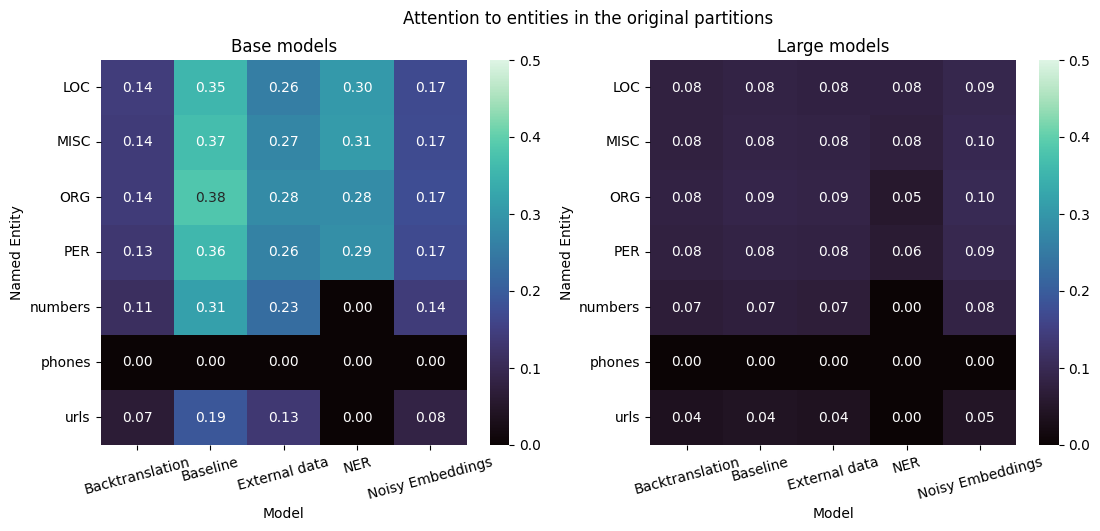

In [26]:
reports_old = [base_ent_attn_old,ner_ent_attn_old,ext_attn_old,back_ent_attn_old,noisy_ent_attn_old]
large_reports_old = [large_base_ent_attn_old,large_ner_ent_attn_old,large_ext_ent_attn_old,large_back_ent_attn_old,large_noise_ent_attn_old]
names_old = ['Baseline','NER','External data','Backtranslation','Noisy Embeddings']

plt.figure(figsize=(13,5))
plt.suptitle('Attention to entities in the original partitions')
plt.subplot(1,2,1)
ents, att, n = [], [], []
for d in reports_old:
    ents += list(d.keys())
    att += list(d.values())
    n += [names_old[reports_old.index(d)]] * len(d)
chart = pd.DataFrame({'Named Entity':ents,
                     'Attention':att,
                     'Model':n,
                     'Size':['Base']*len(ents)})
sns.heatmap(chart.pivot(index='Named Entity',columns='Model',values='Attention'),annot=True,fmt='.2f',cmap='mako',vmax=0.5,vmin=0)
plt.yticks(rotation=0)
plt.xticks(rotation=15)
plt.title('Base models')

plt.subplot(1,2,2)
ents, att, n = [], [], []
for d in large_reports_old:
    ents += list(d.keys())
    att += list(d.values())
    n += [names_old[large_reports_old.index(d)]] * len(d)
large_chart = pd.DataFrame({'Named Entity':ents,
                                    'Attention':att,
                                    'Model':n,
                                    'Size':['Large']*len(ents)})
sns.heatmap(large_chart.pivot(index='Named Entity',columns='Model',values='Attention'),annot=True,fmt='.2f',cmap='mako',vmax=0.5,vmin=0)
plt.yticks(rotation=0)
plt.xticks(rotation=15)
plt.title('Large models')
plt.show()

## Comparison

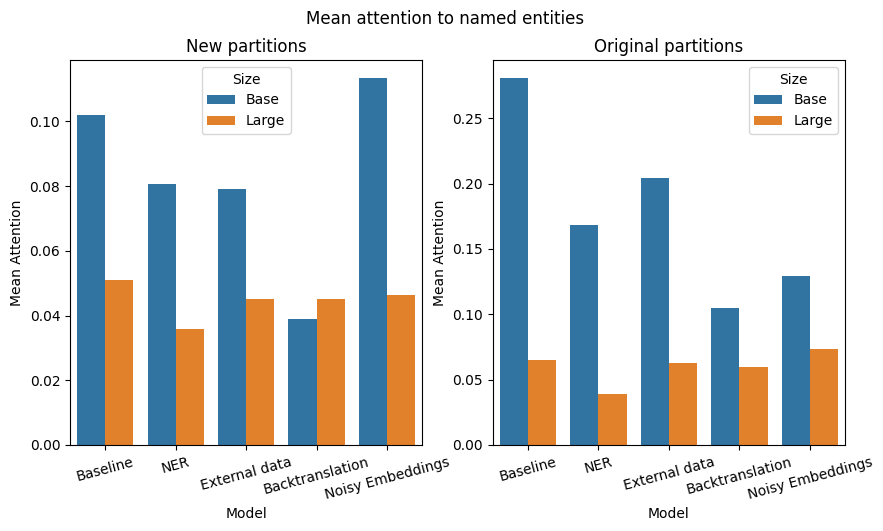

In [27]:
plt.figure(figsize=(10,5))
plt.suptitle('Mean attention to named entities')
plt.subplot(1,2,1)
chart = pd.DataFrame({'Model':names_new,'Mean Attention':[get_mean(d) for d in reports_new],'Size':['Base']*len(names_new)})
chart = pd.concat([chart,pd.DataFrame({'Model':names_new,'Mean Attention':[get_mean(d) for d in large_reports_new],'Size':['Large']*len(names_new)})])
sns.barplot(chart, x='Model', y='Mean Attention', hue='Size')
plt.xticks(rotation=15)
plt.title('New partitions')

plt.subplot(1,2,2)
chart = pd.DataFrame({'Model':names_old,'Mean Attention':[get_mean(d) for d in reports_old],'Size':['Base']*len(names_old)})
chart = pd.concat([chart,pd.DataFrame({'Model':names_old,'Mean Attention':[get_mean(d) for d in large_reports_old],'Size':['Large']*len(names_old)})])
sns.barplot(chart, x='Model', y='Mean Attention', hue='Size')
plt.xticks(rotation=15)
plt.title('Original partitions')
plt.show()